## Задачи:
Обучить модель https://huggingface.co/cointegrated/rubert-tiny2 на задаче мультиклассовой классификации текстов.

1. Обучить классификатор с cls_pooling и mean_pooling.
2. Посчитать метрики: F1-Score, Precision, Recall.
3. Сравнить метрики полученные при использовании разных стратегий пулинга.

## Установка и импорт библиотек

In [ ]:
!pip install datasets

In [ ]:
import torch
from torch.utils.data import TensorDataset
from transformers import AutoModel, AutoTokenizer
from tqdm import tqdm
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

from datasets import load_dataset, DatasetDict
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns

## Загрузка и подготовка данных

In [ ]:
ds = load_dataset("blinoff/kinopoisk")

README.md: 0.00B [00:00, ?B/s]

kinopoisk.jsonl:   0%|          | 0.00/143M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/36591 [00:00<?, ? examples/s]

In [ ]:
ds

DatasetDict({
    train: Dataset({
        features: ['part', 'movie_name', 'review_id', 'author', 'date', 'title', 'grade3', 'grade10', 'content'],
        num_rows: 36591
    })
})

In [ ]:
None in ds['train']['content']

False

In [ ]:
ds['train'][0]

{'part': 'top250',
 'movie_name': 'Блеф (1976)',
 'review_id': '17144',
 'author': 'Come Back',
 'date': datetime.datetime(2011, 9, 24, 0, 0),
 'title': 'Плакали наши денежки ©',
 'grade3': 'Good',
 'grade10': '10',
 'content': '\n"Блеф»\xa0—\xa0одна из\xa0моих самых любимых комедий.\n\nЭтот фильм я\xa0наверно смотрел раз\xa0сто, нет\xa0я конечно блефую, я\xa0видел его\xa0куда больше. Не\xa0могу не\xa0выразить своё восхищение главными действующими лицами этого фильма. Начну с\xa0Адриано Челентано для\xa0которого как\xa0я считаю это\xa0лучшая роль в\xa0кино. Великолепный актёр, неплохой певец, странно что\xa0на его\xa0родине в\xa0Италии его\xa0песни мало кто\xa0слушает. Ну\xa0я думаю что\xa0и итальянцы и\xa0французы привыкли к\xa0тому, что\xa0у нас\xa0до сих\xa0их актёры популярней чем\xa0даже на\xa0своей родине. Да, такой вот\xa0парадокс. Челентано конечно профессионал своего дела, комик с\xa0серьёзным выражением лица. Он\xa0смешон ещё\xa0и потому, что\xa0одновременно так\xa0серъёзен. 

Для оценки по десятибальной шкале **для классификации преведем все значения к integer** в диапазоне от 1 до 10.

In [ ]:
def standardize_column(p):
    p['grade10'] = int(round(float(p['grade10'])))
    p['grade10'] = 0 if p['grade10'] < 0 else p['grade10']
    p['grade10'] = 10 if p['grade10'] > 10 else p['grade10']
    return p

ds['train'] = ds['train'].map(standardize_column)

Map:   0%|          | 0/36591 [00:00<?, ? examples/s]

In [ ]:
Counter(ds['train']['grade10'])

Counter({10: 13484,
         0: 13342,
         7: 1031,
         9: 2954,
         8: 1965,
         5: 636,
         1: 865,
         6: 739,
         2: 553,
         4: 506,
         3: 516})

In [ ]:
ds = ds.remove_columns(['part', 'movie_name', 'review_id', 'author', 'date',  'grade3', 'title'])

In [ ]:
review_lens = [len(str(t)) for t in ds['train']['content']]

**Распределение длин примеров**

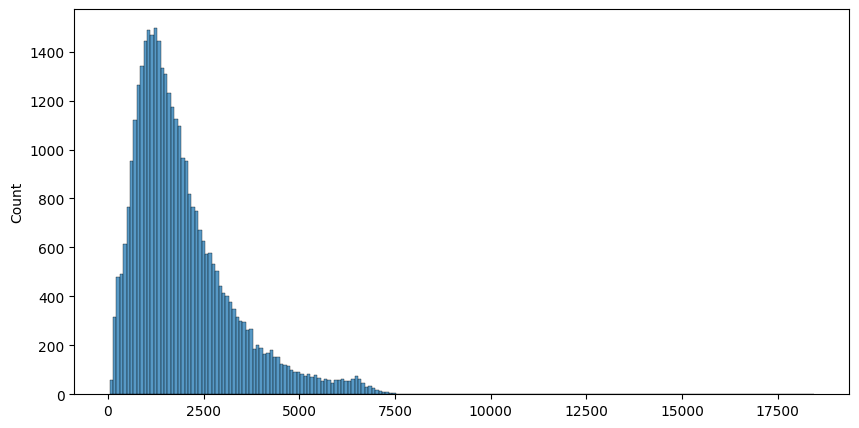

In [ ]:
plt.figure(figsize=(10, 5))
sns.histplot(data=review_lens)
plt.show()

**Разобьем на train и test части**

In [ ]:
train_test_split = ds['train'].train_test_split(test_size=0.2, seed=42)
validation_test_split = train_test_split['test'].train_test_split(test_size=0.5, seed=42)

In [ ]:
final_dataset = DatasetDict({
    'train': train_test_split['train'],
    'validation': validation_test_split['train'],
    'test': validation_test_split['test']
})

In [ ]:
final_dataset

DatasetDict({
    train: Dataset({
        features: ['grade10', 'content'],
        num_rows: 29272
    })
    validation: Dataset({
        features: ['grade10', 'content'],
        num_rows: 3659
    })
    test: Dataset({
        features: ['grade10', 'content'],
        num_rows: 3660
    })
})

In [ ]:
print(final_dataset['train'][0])

{'grade10': 1, 'content': '\n      «Фильм основан на\xa0реальных событиях»\xa0— уже\xa0начиная с\xa0этой фразы можно понять, насколько лживыми бывают некоторые выскочки-режиссёры. И\xa0насколько лживы их\xa0творения. Похоже, в\xa0наше время любой шлак «основан на…», будь то\xa0хоть гибель Солнечной Системы в\xa0середине двадцатого века.\n\n\n\nЯсен пень, что\xa0скандальный «5 дней в\xa0августе» от\xa0и до\xa0не состоит из\xa0правды. Правда тут\xa0действительно адски пострадала, сюжет воистину фантастический, если не\xa0фэнтезийный. Из\xa0всего увиденного правда\xa0— то, что\xa0актёр, игравший Саакашвили, очень на\xa0него похож. А\xa0в целом уже\xa0не актуально говорить про\xa0всю провокацию, вылившуюся с\xa0экрана при\xa0просмотре. Ренни Харлин изобрёл кость, которую без\xa0зазрения совести можно кинуть России и\xa0всему Кавказу. Он\xa0потратил кучу долларов на\xa0спецэффекты, когда мог\xa0отдать хоть на\xa0благотворительность, но\xa0не для\xa0того, мол, моя\xa0роза цвела. Поэтому я\xa

## Токенизация

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('cointegrated/rubert-tiny2')

tokenizer_config.json:   0%|          | 0.00/401 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [ ]:
def tokenize_data(data, max_length=512):
    texts = list(data['content'])
    tokens = tokenizer.batch_encode_plus(
        texts,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    return tokens


train_tokens = tokenize_data(final_dataset['train'])
val_tokens = tokenize_data(final_dataset['validation'])
test_tokens = tokenize_data(final_dataset['test'])

In [ ]:
print(train_tokens.input_ids.shape)

torch.Size([29272, 512])


In [ ]:
train_dataset = TensorDataset(
    train_tokens['input_ids'],
    train_tokens['attention_mask'],
    torch.tensor(final_dataset['train']['grade10'], dtype=torch.long),
)

val_dataset = TensorDataset(
    val_tokens['input_ids'],
    val_tokens['attention_mask'],
    torch.tensor(final_dataset['validation']['grade10'], dtype=torch.long),
)

test_dataset = TensorDataset(
    test_tokens['input_ids'],
    test_tokens['attention_mask'],
    torch.tensor(final_dataset['test']['grade10'], dtype=torch.long),
)

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [ ]:
device = 'mps' if torch.backends.mps.is_built() else 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)

cuda


## Дообучение

In [ ]:
import torch.nn.functional as F


def avg_train_and_val(
        model,
        loader: DataLoader,
        epoch,
        num_epochs,
        optimizer,
        mode,
):
    total_loss = 0

    for input_ids, attention_mask, labels in tqdm(loader, desc=f'{mode} epoch {epoch}/{num_epochs}...'):
        if mode == 'Training':
            optimizer.zero_grad()

        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        logits = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )

        outputs_loss = F.cross_entropy(logits, labels)

        total_loss += outputs_loss.item()

        if mode == 'Training':
            outputs_loss.backward()
            optimizer.step()

    loss = total_loss / len(loader)
    print(f'{mode} epoch {epoch + 1}/{num_epochs}: {mode} Loss: {loss:.4f}')

In [ ]:
def avg_train(
        model,
        train_loader,
        val_loader,
        optimizer,
        num_epochs=3,
):
    for epoch in range(num_epochs):
        model.train()

        avg_train_and_val(model, train_loader, epoch, num_epochs, optimizer, mode='Training')

        model.eval()

        with torch.no_grad():
            avg_train_and_val(model, val_loader, epoch, num_epochs, optimizer, mode='Validating')

In [ ]:
class Classifier(torch.nn.Module):
    def __init__(self, pretrained, pooling_type):
        super(Classifier, self).__init__()
        self.pretrained = pretrained
        self.classifier = torch.nn.Linear(312, 11)
        self.pooling_type = pooling_type

    def mean_pooling(self, token_embeddings: torch.Tensor, attention_mask: torch.Tensor):
        input_mask_expanded = (
            attention_mask.unsqueeze(-1)
            .expand(token_embeddings.shape)
            .float()
        )
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

    def cls_pooling(self, token_embeddings):
        return token_embeddings[:, 0]

    def forward(self, input_ids, attention_mask):
        outputs = self.pretrained(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )  # shape = [batch_size, seq_len, bert_size]

        if self.pooling_type == "mean":
            embeddings = self.mean_pooling(outputs.last_hidden_state, attention_mask)
        else:
            embeddings = self.cls_pooling(outputs.last_hidden_state)
        logits = self.classifier(embeddings)

        return logits

In [ ]:
def eval_model(model, loader):
    preds = []
    labels = []
    model.eval()
    with torch.no_grad():
        for input_ids, attention_mask, label in tqdm(loader):
            logits = model(
                input_ids=input_ids.to(device),
                attention_mask=attention_mask.to(device),
            )

            sentiment = torch.argmax(logits, dim=1).tolist()
            for i in range(len(label)):
                preds.append(sentiment[i])
                labels.append(label[i].item())

    return preds, labels

In [ ]:
pretrained = AutoModel.from_pretrained('cointegrated/rubert-tiny2')

Обучаем модель **с использованием Mean-пулинга**
<br>В этом подходе мы усредняем эмбеддинги всех токенов с учётом attention mask

In [ ]:
mean_classifier = Classifier(pretrained, 'mean')
mean_classifier = mean_classifier.to(device)

mean_optimizer = torch.optim.AdamW(mean_classifier.parameters(), lr=5e-5)

In [ ]:
avg_train(mean_classifier, train_loader, val_loader, mean_optimizer)

Training epoch 0/3...: 100%|██████████| 1830/1830 [03:22<00:00,  9.02it/s]


Training epoch 1/3: Training Loss: 0.6735


Validating epoch 0/3...: 100%|██████████| 229/229 [00:06<00:00, 36.29it/s]


Validating epoch 1/3: Validating Loss: 0.5246


Training epoch 1/3...: 100%|██████████| 1830/1830 [03:22<00:00,  9.03it/s]


Training epoch 2/3: Training Loss: 0.4449


Validating epoch 1/3...: 100%|██████████| 229/229 [00:06<00:00, 36.10it/s]


Validating epoch 2/3: Validating Loss: 0.5157


Training epoch 2/3...: 100%|██████████| 1830/1830 [03:22<00:00,  9.03it/s]


Training epoch 3/3: Training Loss: 0.2939


Validating epoch 2/3...: 100%|██████████| 229/229 [00:06<00:00, 36.12it/s]

Validating epoch 3/3: Validating Loss: 0.6404


In [ ]:
mean_preds, mean_labels = eval_model(mean_classifier, test_loader)

100%|██████████| 458/458 [00:06<00:00, 69.26it/s]


In [ ]:
print(mean_preds)
print(mean_labels)

[1, 10, 0, 0, 0, 8, 10, 9, 9, 5, 0, 0, 9, 4, 10, 10, 10, 10, 10, 0, 10, 10, 10, 10, 0, 0, 10, 9, 10, 10, 0, 10, 10, 0, 0, 10, 0, 8, 10, 8, 10, 1, 10, 0, 10, 10, 10, 10, 7, 0, 10, 10, 10, 0, 0, 0, 10, 5, 10, 0, 3, 9, 8, 0, 5, 10, 7, 0, 0, 10, 0, 0, 10, 0, 7, 6, 1, 10, 0, 9, 10, 10, 0, 10, 0, 8, 0, 2, 0, 10, 10, 10, 0, 10, 3, 0, 0, 10, 10, 0, 10, 5, 10, 9, 6, 10, 8, 0, 10, 10, 0, 10, 10, 10, 10, 0, 0, 0, 0, 10, 10, 9, 10, 9, 0, 10, 0, 10, 10, 7, 10, 0, 10, 1, 0, 0, 10, 0, 0, 10, 9, 10, 0, 0, 0, 0, 10, 10, 9, 4, 10, 10, 9, 0, 5, 10, 3, 7, 8, 9, 10, 7, 9, 8, 10, 10, 10, 0, 9, 8, 0, 9, 10, 0, 8, 0, 0, 0, 10, 8, 5, 7, 8, 0, 0, 10, 6, 10, 10, 8, 10, 8, 10, 0, 0, 0, 0, 4, 0, 7, 0, 10, 10, 5, 0, 0, 0, 0, 9, 0, 8, 0, 10, 10, 0, 10, 10, 10, 10, 0, 10, 10, 10, 10, 0, 8, 0, 0, 10, 10, 8, 0, 10, 10, 1, 0, 10, 10, 0, 10, 10, 0, 9, 0, 10, 0, 10, 9, 0, 0, 10, 10, 1, 0, 0, 0, 0, 10, 6, 0, 0, 0, 10, 3, 10, 7, 0, 10, 1, 9, 5, 3, 9, 10, 9, 0, 10, 10, 10, 10, 0, 9, 4, 0, 10, 1, 10, 0, 10, 9, 9, 0, 9, 9, 0, 

Обучаем модель **с использованием CLS-пулинга**
<br>В этом подходе мы используем встроенное pooled_output от RuBERT (токен [CLS])

In [ ]:
cls_classifier = Classifier(pretrained, 'cls')
cls_classifier = cls_classifier.to(device)

cls_optimizer = torch.optim.AdamW(cls_classifier.parameters(), lr=5e-5)

In [ ]:
avg_train(cls_classifier, train_loader, val_loader, cls_optimizer)

Training epoch 0/3...: 100%|██████████| 1830/1830 [03:20<00:00,  9.12it/s]


Training epoch 1/3: Training Loss: 0.1676


Validating epoch 0/3...: 100%|██████████| 229/229 [00:06<00:00, 36.46it/s]


Validating epoch 1/3: Validating Loss: 1.0120


Training epoch 1/3...: 100%|██████████| 1830/1830 [03:20<00:00,  9.14it/s]


Training epoch 2/3: Training Loss: 0.0463


Validating epoch 1/3...: 100%|██████████| 229/229 [00:06<00:00, 36.42it/s]


Validating epoch 2/3: Validating Loss: 1.0795


Training epoch 2/3...: 100%|██████████| 1830/1830 [03:20<00:00,  9.14it/s]


Training epoch 3/3: Training Loss: 0.0279


Validating epoch 2/3...: 100%|██████████| 229/229 [00:06<00:00, 36.54it/s]

Validating epoch 3/3: Validating Loss: 1.1522


In [ ]:
cls_preds, cls_labels = eval_model(cls_classifier, test_loader)

100%|██████████| 458/458 [00:06<00:00, 70.01it/s]


In [ ]:
print(cls_preds)
print(cls_labels)

[1, 10, 0, 0, 0, 8, 10, 10, 9, 5, 0, 0, 10, 4, 10, 0, 10, 10, 10, 0, 10, 10, 10, 0, 0, 0, 10, 9, 10, 10, 0, 10, 10, 0, 0, 10, 9, 8, 10, 8, 10, 1, 9, 0, 10, 9, 10, 10, 7, 0, 10, 10, 10, 10, 0, 0, 10, 5, 10, 0, 3, 0, 8, 0, 5, 10, 7, 0, 0, 10, 0, 0, 10, 0, 7, 6, 1, 9, 0, 9, 0, 10, 0, 10, 0, 8, 0, 2, 0, 10, 10, 10, 0, 10, 3, 0, 0, 10, 10, 0, 10, 5, 10, 9, 6, 10, 8, 0, 10, 10, 0, 0, 10, 10, 10, 0, 0, 9, 0, 10, 10, 9, 10, 9, 0, 10, 0, 10, 10, 7, 0, 0, 10, 1, 0, 0, 10, 0, 0, 10, 9, 10, 0, 0, 0, 0, 10, 10, 10, 4, 10, 10, 9, 10, 5, 10, 3, 7, 0, 9, 7, 6, 9, 9, 10, 10, 10, 0, 9, 8, 0, 9, 10, 0, 7, 0, 0, 1, 10, 8, 5, 7, 8, 0, 0, 10, 6, 10, 10, 8, 10, 6, 10, 0, 0, 0, 0, 4, 0, 10, 0, 10, 10, 5, 0, 0, 0, 0, 9, 0, 8, 0, 10, 10, 0, 10, 10, 10, 10, 0, 10, 10, 10, 10, 0, 5, 0, 0, 10, 10, 8, 0, 10, 0, 1, 0, 10, 0, 0, 10, 10, 0, 9, 0, 10, 0, 10, 9, 0, 0, 10, 10, 1, 0, 0, 0, 0, 10, 6, 0, 0, 0, 10, 3, 10, 5, 0, 10, 1, 9, 5, 3, 9, 10, 0, 10, 0, 10, 10, 10, 0, 9, 4, 0, 0, 0, 10, 0, 10, 9, 9, 0, 0, 9, 0, 10, 6,

## Сравнение двух подходов

Метрики для MeanPool

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
accuracy = accuracy_score(mean_labels, mean_preds)
precision = precision_score(mean_labels, mean_preds, average='macro')
recall = recall_score(mean_labels, mean_preds, average='macro')
f1 = f1_score(mean_labels, mean_preds, average='macro')
report = classification_report(mean_labels, mean_preds)

print(f'Mean Pooling Metrics')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
print(report)

Accuracy: 0.8172131147540984
Precision: 0.8467339945065604
Recall: 0.7438500842292215
F1-score: 0.7882467313675338
              precision    recall  f1-score   support

           0       0.86      0.78      0.82      1398
           1       0.88      0.73      0.80        89
           2       0.86      0.75      0.80        51
           3       0.98      0.72      0.83        58
           4       0.93      0.77      0.85        53
           5       0.89      0.66      0.76        62
           6       0.84      0.66      0.74        62
           7       0.74      0.74      0.74        92
           8       0.84      0.70      0.76       195
           9       0.71      0.74      0.72       297
          10       0.79      0.93      0.86      1303

    accuracy                           0.82      3660
   macro avg       0.85      0.74      0.79      3660
weighted avg       0.82      0.82      0.82      3660



Метрики для CLSPool

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
accuracy = accuracy_score(cls_labels, cls_preds)
precision = precision_score(cls_labels, cls_preds, average='macro')
recall = recall_score(cls_labels, cls_preds, average='macro')
f1 = f1_score(cls_labels, cls_preds, average='macro')
report = classification_report(cls_labels, cls_preds)

print(f'CLS Pooling Metrics')
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-score: {f1}')
print(report)

Accuracy: 0.8158469945355191
Precision: 0.8312655797465702
Recall: 0.7429440904651209
F1-score: 0.7818687056630743
              precision    recall  f1-score   support

           0       0.84      0.79      0.82      1398
           1       0.93      0.72      0.81        89
           2       0.79      0.75      0.77        51
           3       0.95      0.72      0.82        58
           4       0.93      0.79      0.86        53
           5       0.75      0.68      0.71        62
           6       0.72      0.68      0.70        62
           7       0.84      0.71      0.77        92
           8       0.85      0.69      0.76       195
           9       0.72      0.74      0.73       297
          10       0.80      0.91      0.85      1303

    accuracy                           0.82      3660
   macro avg       0.83      0.74      0.78      3660
weighted avg       0.82      0.82      0.81      3660



## Выводы

Сравнили два способа агрегации эмбеддингов для задачи мультиклассовой классификации:

- **CLS Pooling**: использует эмбеддинг [CLS]-токена, обучаемый напрямую.
- типичен для BERT
- **Mean Pooling**: усредняет все эмбеддинги токенов входной последовательности, игнорируя [CLS].
- также распространён

Результаты показали, что:
- Разница несущественна
- *по крайней мере на этих данных*
- **Mean Pooling лучше на доли процента**

| Pooling Method | Accuracy | F1-Score |
|----------------|----------|----------|
| CLS            |  81.58%  |  78.18   |
| Mean           |  81.72%  |  78.82   |